In [ ]:
#Paleo-Crustal thickness maps

Age range 170-150 Ma: 364 samples
Plot saved as PDF: crustal_thickness_170_150Ma.pdf


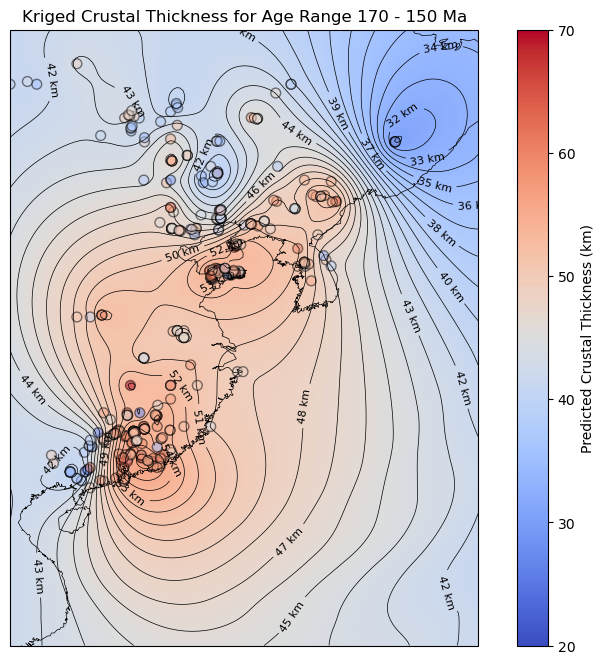

Age range 140-130 Ma: 384 samples
Plot saved as PDF: crustal_thickness_140_130Ma.pdf


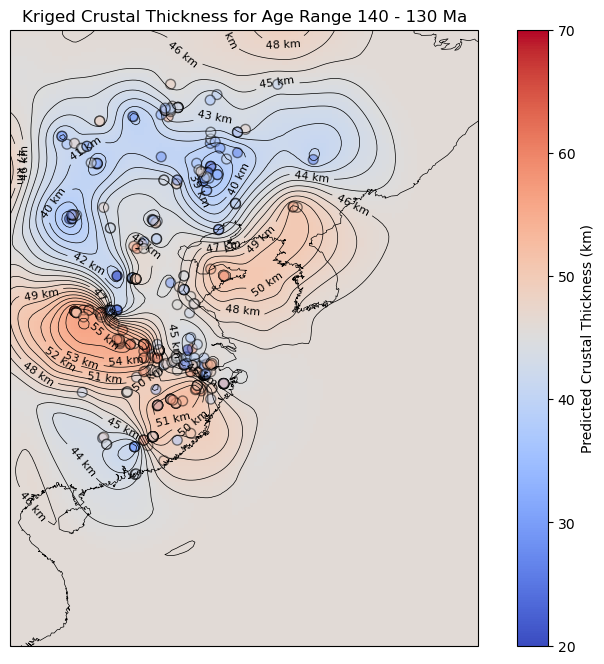

Age range 120-100 Ma: 374 samples
Plot saved as PDF: crustal_thickness_120_100Ma.pdf


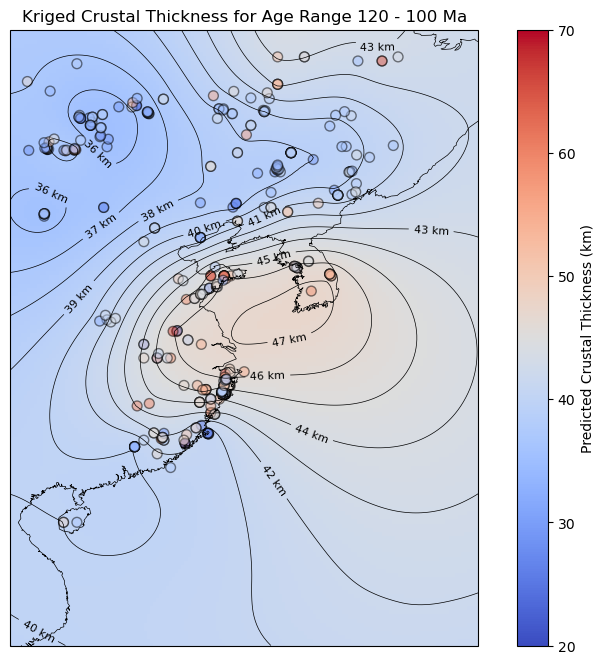

In [7]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.crs import PlateCarree
import geopandas as gpd
from pykrige.ok import OrdinaryKriging  # Ordinary Kriging

# File path to your shapefile
coastline_shapefile = '/Applications/GPlates_2.5.0/GeoData/FeatureCollections/Coastlines/Shapefile/Global_EarthByte_GPlates_PresentDay_Coastlines_Polyline.shp'

# Load the coastline shapefile
coastline_gdf = gpd.read_file(coastline_shapefile)

# File path for your CSV data
file_path = '/Users/jianpingzhou/work/Papers/Andean-type/data/Whole_E_Asia.csv'
df = pd.read_csv(file_path)

# Ensure Predicted_Crustal_Thickness is in kilometers (if not already)
df['Predicted_Crustal_Thickness'] = df['Predicted_Crustal_Thickness'].astype(float)

# Group data by Age, Latitude, and Longitude to calculate the median crustal thickness
grouped = (
    df.groupby(['Age', 'Lat', 'Lon'])['Predicted_Crustal_Thickness']
    .agg(['median', 'std'])
    .reset_index()
    .rename(columns={'median': 'Median_Crustal_Thickness', 'std': 'Error'})
)

# Function to filter data by the new age range
def filter_by_age_range(df, age_range):
    min_age, max_age = age_range
    return df[(df['Age'] <= min_age) & (df['Age'] > max_age)]

# Function to perform Kriging interpolation
def interpolate_crustal_thickness_kriging(df, resolution=100):
    # Define grid
    lon_min, lon_max = 105, 140  # Set interpolation area longitude bounds
    lat_min, lat_max = 10, 55   # Set interpolation area latitude bounds

    # Create grid for interpolation
    lon_grid = np.linspace(lon_min, lon_max, resolution)
    lat_grid = np.linspace(lat_min, lat_max, resolution)

    # Extract data for kriging
    points_lon = df['Lon'].values
    points_lat = df['Lat'].values
    values = df['Median_Crustal_Thickness'].values

    # Create the kriging model
    kriging_model = OrdinaryKriging(
        points_lon, points_lat, values,
        variogram_model='spherical',  # Choose a variogram model: 'linear', 'power', 'gaussian', 'spherical', etc.
        verbose=False, enable_plotting=False
    )

    # Perform kriging interpolation
    crustal_thickness_grid, _ = kriging_model.execute('grid', lon_grid, lat_grid)

    # Clamp values to realistic range (20 to 70 km)
    crustal_thickness_grid = np.clip(crustal_thickness_grid, 20, 70)

    return lon_grid, lat_grid, crustal_thickness_grid

# Function to save the interpolated crustal thickness plot as a PDF and display it in Jupyter Lab
def save_crustal_thickness_plot_as_pdf(df, age_range, resolution=200, output_path="Mesozoic_crustal_thickness_plot.pdf"):
    min_age, max_age = age_range
    
    if df.empty:
        print(f"No data available for age range {min_age}-{max_age} Ma")
        return  # Skip saving for empty data

    # Perform Kriging interpolation
    lon_grid, lat_grid, crustal_thickness_grid = interpolate_crustal_thickness_kriging(df, resolution)

    # Use PlateCarree projection for WGS84
    projection = ccrs.PlateCarree()

    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=projection)
    
    # Set the extent to the fixed region [West longitude, East longitude, South latitude, North latitude]
    ax.set_extent([105, 140, 10, 55], crs=ccrs.PlateCarree())

    # Add features to the map
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    # Plot the coastline shapefile from Geopandas
    coastline_gdf.plot(ax=ax, edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())

    # Plot the interpolated crustal thickness
    cs = ax.pcolormesh(lon_grid, lat_grid, crustal_thickness_grid, cmap='coolwarm', vmin=20, vmax=70, transform=ccrs.PlateCarree())

    # Add contour lines to the map
    contour_levels = np.arange(20, 71, 1)
    contours = ax.contour(lon_grid, lat_grid, crustal_thickness_grid, levels=contour_levels, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    ax.clabel(contours, inline=True, fontsize=8, fmt='%1.0f km')

    # Add color bar
    cbar = plt.colorbar(cs, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label('Predicted Crustal Thickness (km)')

    # Plot the original data points (median crustal thickness dots) with transparency
    ax.scatter(df['Lon'], df['Lat'], c=df['Median_Crustal_Thickness'], cmap='coolwarm', edgecolor='k', s=50, alpha=0.5, transform=ccrs.PlateCarree())

    # Add title
    plt.title(f'Kriged Crustal Thickness for Age Range {min_age} - {max_age} Ma')

    # Save the plot as a PDF
    plt.savefig(output_path, format='pdf')
    print(f"Plot saved as PDF: {output_path}")

    # Display the plot in Jupyter Lab
    plt.show()

    # Close the plot to free memory
    plt.close()

# Define the specific age ranges for analysis
age_ranges = [(170, 150), (140,130),(120, 100)]  # Modify this as needed

# Plot Kriging-interpolated crustal thickness for each age range and save as PDF
for age_range in age_ranges:
    filtered_df = filter_by_age_range(grouped, age_range)
    
    # Display number of samples for this age range
    sample_count = len(filtered_df)
    print(f"Age range {age_range[0]}-{age_range[1]} Ma: {sample_count} samples")
    
    if not filtered_df.empty:
        pdf_path = f"crustal_thickness_{age_range[0]}_{age_range[1]}Ma.pdf"
        save_crustal_thickness_plot_as_pdf(filtered_df, age_range, resolution=150, output_path=pdf_path)

In [ ]:
###paleo elevation maps

Plot saved as PDF: 0_paleo_elevation_plot_with_contours.pdf


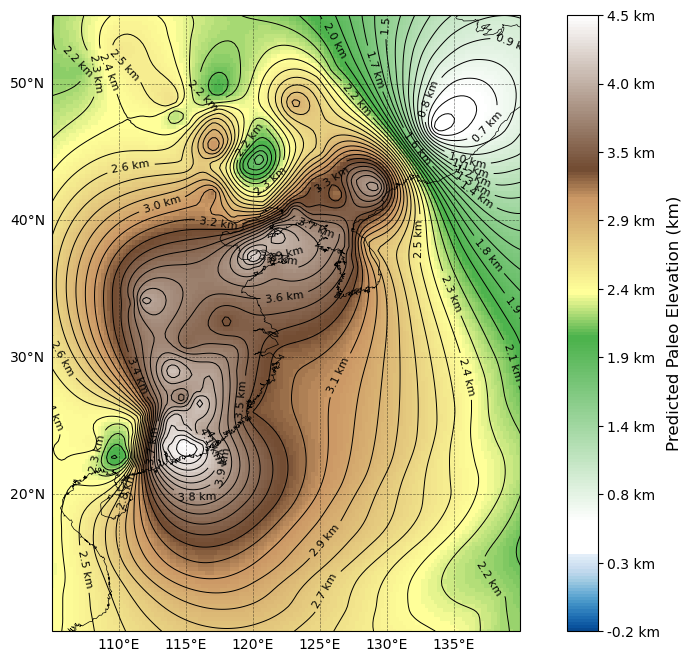

Plot saved as PDF: 0_paleo_elevation_plot_with_contours.pdf


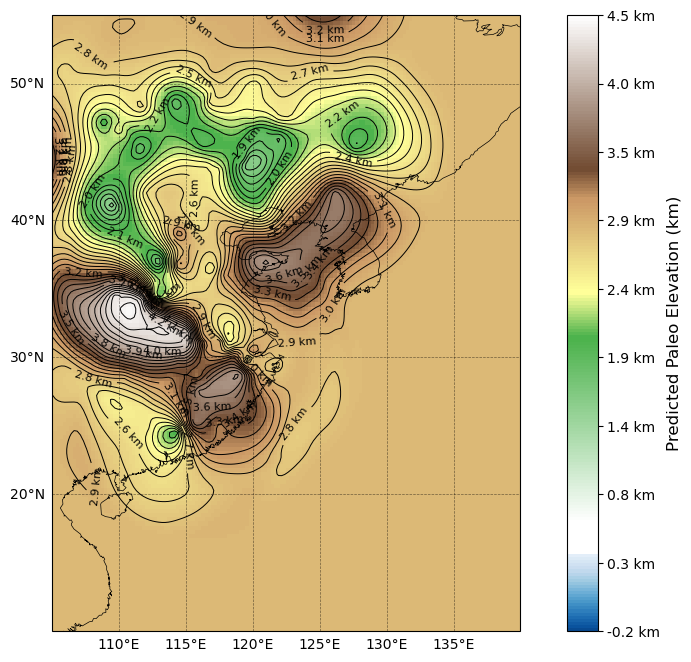

Plot saved as PDF: 0_paleo_elevation_plot_with_contours.pdf


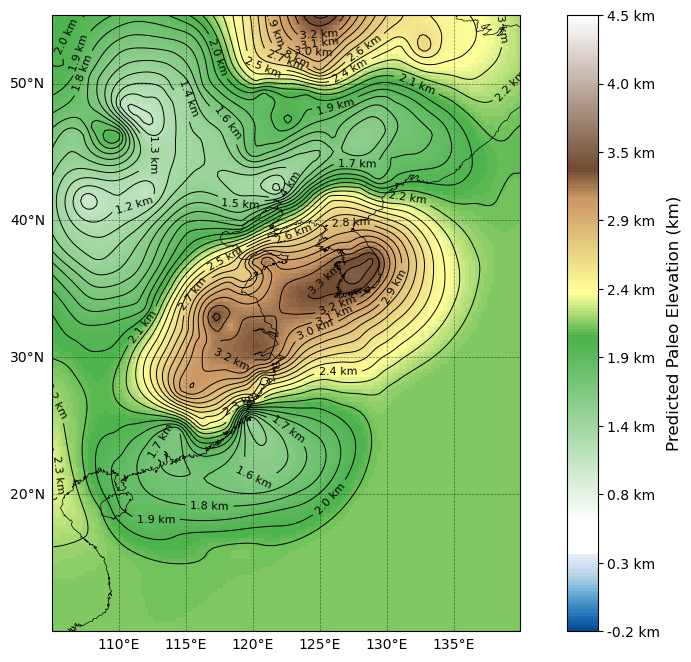

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from pykrige.ok import OrdinaryKriging  # Ordinary Kriging
import matplotlib.colors as mcolors

# File path to your shapefile
coastline_shapefile = '/Applications/GPlates_2.5.0/GeoData/FeatureCollections/Coastlines/Shapefile/Global_EarthByte_GPlates_PresentDay_Coastlines_Polyline.shp'
coastline_gdf = gpd.read_file(coastline_shapefile)

# File path for your CSV data
file_path = '/Users/jianpingzhou/work/Papers/Andean-type/data/Whole_E_Asia.csv'
df = pd.read_csv(file_path)

# Ensure Predicted_Paleo_Elevation is a float
df['Predicted_Paleo_Elevation'] = df['Predicted_Paleo_Elevation'].astype(float)

# Group data by Age, Latitude, and Longitude to calculate the median paleo elevation
grouped = (
    df.groupby(['Age', 'Lat', 'Lon'])['Predicted_Paleo_Elevation']
    .agg(['median', 'std'])
    .reset_index()
    .rename(columns={'median': 'Median_Paleo_Elevation', 'std': 'Error'})
)

# Function to filter data by age range
def filter_by_age_range(df, age_range):
    min_age, max_age = age_range
    return df[(df['Age'] <= min_age) & (df['Age'] > max_age)]

# Function to perform Kriging interpolation
def interpolate_paleo_elevation_kriging(df, resolution=100):
    lon_min, lon_max = 105, 140  # Set interpolation area longitude bounds
    lat_min, lat_max = 10, 55    # Set interpolation area latitude bounds

    # Create grid for interpolation
    lon_grid = np.linspace(lon_min, lon_max, resolution)
    lat_grid = np.linspace(lat_min, lat_max, resolution)

    # Extract data for kriging
    points_lon = df['Lon'].values
    points_lat = df['Lat'].values
    values = df['Median_Paleo_Elevation'].values

    # Create the kriging model
    kriging_model = OrdinaryKriging(
        points_lon, points_lat, values,
        variogram_model='spherical',
        verbose=False, enable_plotting=False
    )

    # Perform kriging interpolation
    paleo_elevation_grid, _ = kriging_model.execute('grid', lon_grid, lat_grid)

    return lon_grid, lat_grid, paleo_elevation_grid

# Custom colormap with deep brown moved lower (now starts at 3.5 km)
def create_custom_colormap():
    ocean_cmap = plt.cm.Blues_r(np.linspace(0.1, 0.9, 25))  # Deep blue for -0.2 to ~-0.05 km
    white_transition = np.array([[1.0, 1.0, 1.0, 1]] * 10)  # White at exactly 0 km

    # Smooth gradient from white to green (0 km to 0.8 km)
    green_gradient = np.linspace([1.0, 1.0, 1.0, 1],  # Start at white
                                 [0.3, 0.7, 0.3, 1],  # Softer light green
                                 60)  # 50 steps

    # Smooth transition from green to yellow (0.8 km to 1.5 km)
    yellow_gradient = np.linspace([0.3, 0.7, 0.3, 1],  # Softer green
                                  [1.0, 1.0, 0.6, 1],  # Pale yellow
                                  15)  # 75 steps

    # Smooth yellow to light brown (1.5 km to 3.0 km)
    brown_gradient = np.linspace([1.0, 1.0, 0.6, 1],  # Pale yellow
                                  [0.8, 0.6, 0.4, 1],  # Light brown
                                  30)  # Adjusted for smooth transition

    # Deep brown gradient from 3.0 km to 3.5 km (previously 4 km)
    deep_brown_gradient = np.linspace([0.8, 0.6, 0.4, 1],  # Light brown
                                       [0.45, 0.3, 0.2, 1],  # Deep brown
                                       10)  # Adjusted for smooth transition

    # White transition from 3.5 km to 4.5 km
    top_white = np.linspace([0.45, 0.3, 0.2, 1],  # Start at deep brown
                            [1.0, 1.0, 1.0, 1],  # End at white
                            50)  # Shortened white transition

    # Merge all sections to create the final colormap
    new_colors = np.vstack((ocean_cmap, white_transition, green_gradient, yellow_gradient, brown_gradient, deep_brown_gradient, top_white))
    return mcolors.ListedColormap(new_colors)

custom_cmap = create_custom_colormap()

# Adjusted max elevation to 4.5 km
vmin, vmax = -0.2, 4.5

# Function to display and save the interpolated paleo elevation plot with lat/lon labels
def display_and_save_paleo_elevation_with_contours(df, age_range, resolution=150, output_path="0_paleo_elevation_plot_with_contours.pdf"):
    min_age, max_age = age_range

    if df.empty:
        print(f"No data available for age range {min_age}-{max_age} Ma")
        return

    # Perform Kriging interpolation
    lon_grid, lat_grid, paleo_elevation_grid = interpolate_paleo_elevation_kriging(df, resolution)

    # Set up WGS84 (EPSG:4326) projection
    projection = ccrs.PlateCarree()

    # Create the plot
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=projection)
    ax.set_extent([105, 140, 10, 55], crs=projection)

    # Add features to the map
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

    # Plot the coastline shapefile
    coastline_gdf.plot(ax=ax, edgecolor='black', linewidth=0.5, transform=projection)

    # Plot the interpolated paleo elevation with fixed colormap
    cs = ax.pcolormesh(lon_grid, lat_grid, paleo_elevation_grid, cmap=custom_cmap, vmin=vmin, vmax=vmax, transform=projection)

    # Overlay contour lines at 0.1 km intervals
    contour_levels = np.arange(vmin, vmax + 0.1, 0.1)
    contours = ax.contour(lon_grid, lat_grid, paleo_elevation_grid, levels=contour_levels, colors='black', linewidths=0.7, transform=projection)
    ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f km')

    # Add standardized color bar
    cbar = plt.colorbar(cs, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label('Predicted Paleo Elevation (km)', fontsize=12)
    cbar.set_ticks(np.linspace(vmin, vmax, 10))
    cbar.ax.set_yticklabels([f'{tick:.1f} km' for tick in np.linspace(vmin, vmax, 10)], fontsize=10)

    # Add Latitude and Longitude gridlines
    gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="black", alpha=0.5)
    gl.top_labels = False  # Hide top labels
    gl.right_labels = False  # Hide right labels
    gl.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
    gl.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    # Save and display the plot
    plt.savefig(output_path, format='pdf', bbox_inches='tight')
    print(f"Plot saved as PDF: {output_path}")
    plt.show()
    plt.close()

# Run for specified age ranges
age_ranges = [(170, 150), (140,130), (120,100)]
for age_range in age_ranges:
    filtered_df = filter_by_age_range(grouped, age_range)
    display_and_save_paleo_elevation_with_contours(filtered_df, age_range)
